# Ovarian cancer data analysis
Train steamboat model on HGSC data.

In [27]:
import os
import scanpy as sc
import squidpy as sq
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'arial'

pltkw = dict(bbox_inches='tight', transparent=True)

In [3]:
import sys
sys.path.append("..")
import steamboat as sf
import steamboat.tools
import torch
device = 'cuda'

In [37]:
import importlib
importlib.reload(steamboat.tools)

<module 'steamboat.tools' from 'G:\\Projects\\Steamboat\\examples\\..\\steamboat\\tools.py'>

In [5]:
# https://www.nature.com/articles/s41590-024-01943-5

## Load data

In [6]:
regenerate = False

h5ad_file = "../../../data/HGSC/ST_Discovery_so.h5ad"
if (not os.path.exists(h5ad_file)) or regenerate:
    adata = sc.read_mtx("G:/data/HGSC/Csv/ST_Discovery_so_counts.mtx").T
    metadata = pd.read_csv("G:/data/HGSC/Csv/ST_Discovery_so_metadata.csv", index_col=0)
    features = pd.read_csv("G:/data/HGSC/Csv/ST_Discovery_so_features.txt", index_col=0, header=None)
    features.index = features.index.str.strip() # remove trailing white space in gene names
    features.index.name = 'gene_symbol'
    adata.obs = metadata
    adata.var = features
    adata.obsm['spatial'] = adata.obs[['x', 'y']].to_numpy()
    adata.write_h5ad("G:/data/HGSC/h5ad/ST_Discovery_so.h5ad")
else:
    adata = sc.read_h5ad(h5ad_file)

In [7]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,samples,patients,sites_binary,cell.types,cell.subtypes,x,y
SMI_T10_F001_c1017,SMI,848,357,SMI_T10_F001,HGSC1,Adnexa,Malignant,Malignant,1493.3500,3151.233
SMI_T10_F001_c102,SMI,731,319,SMI_T10_F001,HGSC1,Adnexa,Malignant,Malignant,2623.2000,3607.450
SMI_T10_F001_c1062,SMI,236,155,SMI_T10_F001,HGSC1,Adnexa,Malignant,Malignant,850.5670,3143.833
SMI_T10_F001_c1064,SMI,609,300,SMI_T10_F001,HGSC1,Adnexa,Malignant,Malignant,3222.7300,3152.586
SMI_T10_F001_c1075,SMI,310,174,SMI_T10_F001,HGSC1,Adnexa,Malignant,Malignant,78.0125,3179.012
...,...,...,...,...,...,...,...,...,...,...
SMI_T14_F020_c5758,SMI,100,63,SMI_T14_F020,HGSC89,Omentum,TNK.cell,CD4.T.cell.DN,5170.4400,431.900
SMI_T14_F020_c734,SMI,141,88,SMI_T14_F020,HGSC89,Omentum,Fibroblast,Fibroblast,768.7000,3188.400
SMI_T14_F020_c875,SMI,78,60,SMI_T14_F020,HGSC89,Omentum,Malignant,Malignant,42.5833,3070.350
SMI_T14_F020_c3288,SMI,104,58,SMI_T14_F020,HGSC89,Omentum,Fibroblast,Fibroblast,48.9889,1751.740


In [8]:
## Metadata and gene sets

sample_metadata = pd.read_excel("../../../data/HGSC/sample_metadata.xlsx", index_col=0, sheet_name='Table 2b', skiprows=1)
sample_metadata = sample_metadata[sample_metadata['dataset'] == 'Discovery']

celltype_signatures = pd.read_excel("G:/data/HGSC/sample_metadata.xlsx", sheet_name='Table 3a', skiprows=2)
mtil_signautures = pd.read_excel("G:/data/HGSC/sample_metadata.xlsx", sheet_name='Table 6a', skiprows=2)
desmoplasia_signautures = pd.read_excel("G:/data/HGSC/sample_metadata.xlsx", sheet_name='Table 5a', skiprows=2)

def purge_gene_sets(df, prefix=''):
    res = {}
    for i in df.columns:
        res[prefix + i] = df[i].dropna().tolist()
    return res
celltype_signatures = pd.read_excel("G:/data/HGSC/sample_metadata.xlsx", index_col=0, sheet_name='Table 3b', skiprows=2).iloc[:, :-3]
genesets = (purge_gene_sets(celltype_signatures, 'sig_') | 
            purge_gene_sets(mtil_signautures, 'mtil_') | 
            purge_gene_sets(mtil_signautures, 'mtil_'))
genesets.keys()
del genesets['sig_Mast.cell']

sample_metadata

,dataset,platform,n_cells,median_tpc,mean_tpc,TMA,patients,sites_binary,age,stage,...,fu_time2,outcome,pfs,BRCA1_Somatic,BRCA2_Somatic,TP53_Somatic,BRCA1_Germline,BRCA2_Germline,TP53_Germline,tmb
profile,,,,,,,,,,,,,,,,,,,,,
SMI_T10_F001,Discovery,SMI,5660,205.0,238.675618,TMA 10,HGSC1,Adnexa,58.0,III,...,775.0,Alive,775.0,WT,P,P,US,US,US,6.80
SMI_T10_F002,Discovery,SMI,8821,364.0,393.318671,TMA 10,HGSC7,Adnexa,58.0,III,...,1013.0,Alive,1013.0,P,WT,LP,US,US,US,0.53
SMI_T10_F003,Discovery,SMI,2881,300.0,445.154460,TMA 10,HGSC8,Adnexa,65.0,IV,...,781.0,Alive,200.0,WT,WT,P,US,US,US,3.16
SMI_T10_F004,Discovery,SMI,3145,286.0,376.895390,TMA 10,HGSC13,Omentum,67.0,III,...,840.0,Dead (disease),161.0,WT,WT,P,US,US,US,2.63
SMI_T10_F005,Discovery,SMI,2187,165.0,267.202561,TMA 10,HGSC15,Adnexa,33.0,IV,...,845.0,Alive,845.0,WT,WT,P,P,US,US,2.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMI_T14_F016,Discovery,SMI,2744,209.0,288.211735,TMA 14,HGSC61,Omentum,70.0,III,...,1955.0,Alive,1955.0,WT,WT,P,US,US,US,1.10
SMI_T14_F017,Discovery,SMI,3376,276.0,368.816647,TMA 14,HGSC63,Omentum,71.0,III,...,407.0,D/c to hospice (likely dead of disease),297.0,WT,WT,P,US,US,US,0.50
SMI_T14_F018,Discovery,SMI,9961,189.0,210.500452,TMA 14,HGSC89,Adnexa,53.0,III,...,1729.0,Dead (disease),412.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


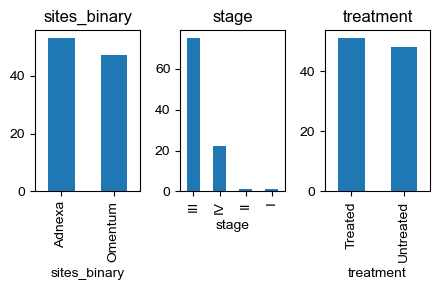

In [9]:
## Find untreated, adnexa samples

columns_of_interest = ['sites_binary', 'stage', 'treatment']
fig, axes = plt.subplots(1, len(columns_of_interest), figsize=(len(columns_of_interest) * 1.5, 3))
for i, column in enumerate(columns_of_interest):
    sample_metadata[column].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()

mask = (sample_metadata['sites_binary'] == 'Adnexa') & (sample_metadata['treatment'] == 'Untreated')
samples_of_interest = sample_metadata.index[mask].tolist()

all_adata = adata[adata.obs['samples'].isin(samples_of_interest)].copy()
all_adata.obs['cell.types.nolc'] = all_adata.obs['cell.types'].str.replace('_LC', '')

In [10]:
### Have a look at the spatial distribution of cells

## Train a Steamboat model

### Process data to create torch dataset

In [12]:
# Separate individual slides
adatas = []
for i in all_adata.obs['samples'].unique():
    temp = all_adata[all_adata.obs['samples'] == i].copy()
    if temp.shape[0] < 100:
        continue
    adatas.append(temp)
    adatas[-1].obs['global'] = 0

# normalize and log transformation
adatas = sf.prep_adatas(adatas, norm=True, log1p=True, scale=False, renorm=False)

# create torch dataset
dataset = sf.make_dataset(adatas, sparse_graph=True, regional_obs=['global'])

  0%|          | 0/27 [00:00<?, ?it/s]

Using ['global'] as regional annotations.


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


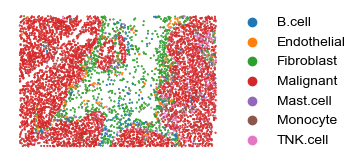

In [13]:
sq.pl.spatial_scatter(adatas[0], color=['cell.types.nolc'], shape=None, figsize=(3.5, 3.5), size=.5, 
                      legend_fontsize=10, cmap='Reds', ncols=3, colorbar=False, vmin=0., wspace=.0, outline=False, frameon=False, title="")

In [14]:
# Move data into vmem

cuda_dataset = None

load_data_into_gpu = True # if you run into OOM on GPU, set this to False
if device == 'cuda' and load_data_into_gpu:
    cuda_dataset = dataset.to('cuda')

### Create model and train

In [15]:
n_heads = 25

sf.set_random_seed(0)
model = sf.Steamboat(adata.var_names.tolist(), n_heads=n_heads, n_scales=3)
model = model.to(device)

use_dataset = cuda_dataset
if use_dataset is None:
    use_dataset = dataset

model.fit(cuda_dataset, entry_masking_rate=0.1, feature_masking_rate=0.1,
          max_epoch=10000, 
          loss_fun=torch.nn.MSELoss(reduction='sum'),
          opt=torch.optim.Adam, opt_args=dict(lr=0.1), stop_eps=1e-3, report_per=200, stop_tol=200, device=device)

[2025-03-02 16:34:31,571::train::INFO] Epoch 1: train_loss 108.29949
[2025-03-02 16:34:52,082::train::INFO] Epoch 201: train_loss 65.23699
[2025-03-02 16:35:13,249::train::INFO] Epoch 401: train_loss 64.43046
[2025-03-02 16:35:35,547::train::INFO] Epoch 601: train_loss 64.02565
[2025-03-02 16:35:58,622::train::INFO] Epoch 801: train_loss 63.11885
[2025-03-02 16:36:21,533::train::INFO] Epoch 1001: train_loss 62.52837
[2025-03-02 16:36:43,575::train::INFO] Epoch 1201: train_loss 61.90503
[2025-03-02 16:37:05,656::train::INFO] Epoch 1401: train_loss 61.92073
[2025-03-02 16:37:26,926::train::INFO] Epoch 1601: train_loss 61.44772
[2025-03-02 16:37:48,203::train::INFO] Epoch 1801: train_loss 61.36187
[2025-03-02 16:38:09,090::train::INFO] Epoch 2001: train_loss 61.31289
[2025-03-02 16:38:31,168::train::INFO] Epoch 2201: train_loss 61.13449
[2025-03-02 16:38:52,523::train::INFO] Epoch 2401: train_loss 61.05229
[2025-03-02 16:39:13,759::train::INFO] Epoch 2601: train_loss 61.05418
[2025-03-02 

Steamboat(
  (spatial_gather): BilinearAttention(
    (bias): NonNegBias(
      (elu): ELU(alpha=1.0)
    )
    (q): NonNegLinear(
      (elu): ELU(alpha=1.0)
    )
    (k_local): NonNegLinear(
      (elu): ELU(alpha=1.0)
    )
    (k_regionals): ModuleList(
      (0): NonNegLinear(
        (elu): ELU(alpha=1.0)
      )
    )
    (w_ego): NonNegScale(
      (elu): ELU(alpha=1.0)
    )
    (tanh): Tanh()
    (v): NonNegLinear(
      (elu): ELU(alpha=1.0)
    )
    (cosine_similarity): CosineSimilarity()
  )
)

### Save model

In [16]:
torch.save(model.state_dict(), 'saved_models/hgsc.pth')

### Calculate attention scores and save AnnData

In [17]:
sf.tools.calc_obs(adatas, dataset, model, get_recon=True)
sf.tools.gather_obs(all_adata, adatas)

  0%|          | 0/27 [00:00<?, ?it/s]

In [18]:
all_adata.write_h5ad("saved_h5ad/hgsc.h5ad")

In [19]:
# Embedding for cell-cell interaction?
# Could there be two pairs of cell types with similar interaction?
# E.g.???

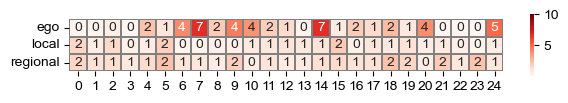

In [22]:
head_weights = sf.tools.calc_head_weights(adatas, model)
sf.tools.plot_head_weights(head_weights)

## Metagene interpretation: cell types and states

(<Figure size 800x500 with 6 Axes>,
 <Axes: xlabel='Global environment metagenes'>)

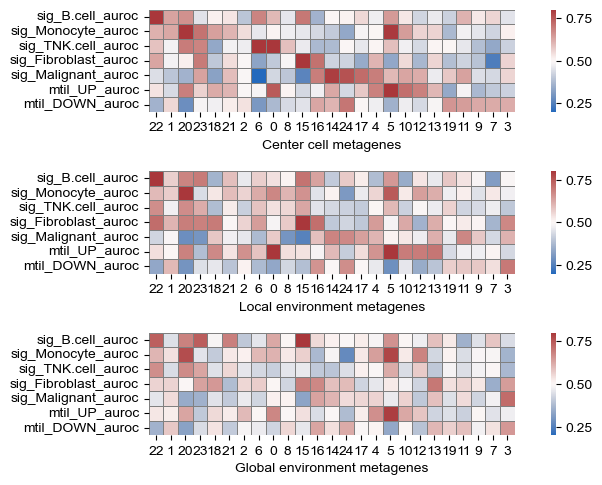

In [23]:
gene_df = sf.tools.calc_var(model)
sig_df = sf.tools.calc_geneset_auroc(gene_df, genesets)
metagene_order = sf.tools.calc_geneset_auroc_order(sig_df)
sf.tools.plot_geneset_auroc(sig_df, metagene_order)

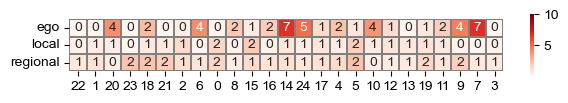

In [24]:
sf.tools.plot_head_weights(head_weights, 100, metagene_order)

C:\Users\lshh\AppData\Local\Temp\ipykernel_18608\3279536217.py:5: FutureWarning: The provided callable <function median at 0x0000020F95881580> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  plt_df = pd.pivot_table(plt_df, index=["samples"], columns=["cell.types.nolc"], values=[f"q_{i_head}"], aggfunc=np.median)
C:\Users\lshh\AppData\Local\Temp\ipykernel_18608\3279536217.py:5: FutureWarning: The provided callable <function median at 0x0000020F95881580> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  plt_df = pd.pivot_table(plt_df, index=["samples"], columns=["cell.types.nolc"], values=[f"q_{i_head}"], aggfunc=np.median)


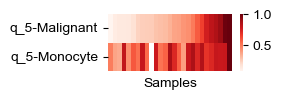

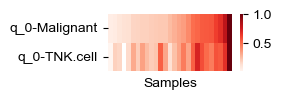

In [25]:
def plot_helper(all_adata, i_head, celltypes):
    plt_df = all_adata.obs.copy()
    plt_df[f'q_{i_head}'] = all_adata.obsm['q'][:, i_head]
    plt_df = plt_df[plt_df['cell.types.nolc'].isin(celltypes)]
    plt_df = pd.pivot_table(plt_df, index=["samples"], columns=["cell.types.nolc"], values=[f"q_{i_head}"], aggfunc=np.median)
    plt_df = plt_df.sort_values(by=(f"q_{i_head}", celltypes[0]))
    
    fig, ax = plt.subplots(figsize=(2, 0.75))
    sns.heatmap((plt_df / plt_df.max()).T, ax=ax, cmap='Reds')
    ax.set_xticks([])
    ax.set_ylabel('')
    ax.set_xlabel('Samples')

plot_helper(all_adata, 5, ['Malignant', 'Monocyte'])
plot_helper(all_adata, 0, ['Malignant', 'TNK.cell'])

In [28]:
# investigate the overlap between Mtil and Monocyte (Up)
# This part is completely from the original publication.
# It has nothing to do with Steamboat
immune_til = pd.read_excel("G:/data/HGSC/sample_metadata.xlsx", index_col=None, sheet_name='Table 4a', skiprows=1)
immune_til = purge_gene_sets(immune_til)
immune_genes = set()
for k, v in immune_til.items():
    if 'Up' in k:
        immune_genes |= set(v)

# Define the parameters of the test
M = all_adata.shape[1]  # Total population size
n = len(set(genesets['mtil_UP']))  # Number of successes in the population
N = len(immune_til['Monocyte (Up)'])   # Sample size
k = len(set(genesets['mtil_UP']) & set(immune_til['Monocyte (Up)']))   # Number of successes in the sample

# Calculate the p-value
p_value = sp.stats.hypergeom.sf(k-1, M, n, N)

print("P-value:", p_value)

P-value: 2.824042372846463e-06


## Attention map interpretation: Cell-cell interaction

In [38]:
steamboat_cci = sf.tools.calc_interaction(adatas, model, 'samples', 'cell.types.nolc')
adjacency_cci = sf.tools.calc_adjacency_freq(adatas, 'samples', 'cell.types.nolc')

In [46]:
def melt_helper(x):
    x_melt = x.melt(ignore_index=False)
    x_melt['variable'] = x_melt.index + '_' + x_melt['variable']
    return x_melt

cellchat_corr_dict = {}
cellchat_melt_dict = {}

cellchat_dict = {}

for k, v in steamboat_cci.items():
    cellchat_res_path = f"../data/Ex1_hgsc/cellchat/{k}.csv"
    if os.path.isfile(cellchat_res_path):
        # print(cellchat_res_path)
        cellchat = pd.read_csv(cellchat_res_path, index_col=0)
        if (cellchat == 0).all().all():
            print(cellchat_res_path, 'all zero. Ignore.')
            continue
            
        cellchat_dict[k] = cellchat
        mine = v.copy()
        cellchat_melt = melt_helper(cellchat + cellchat.T)
        mine_melt = melt_helper(mine)
        
        adjacency_melt = melt_helper(adjacency_cci[k])
        adjacency_melt.columns = ['variable', 'value_adjacency']
        
        all_melt = pd.merge(cellchat_melt, mine_melt, on='variable', suffixes=['_cellchat', '_steamboat'])
        all_melt = pd.merge(all_melt, adjacency_melt, on='variable')
        
        corr_res = sp.stats.spearmanr(all_melt['value_cellchat'], all_melt['value_steamboat'])
        cellchat_melt_dict[k] = all_melt
        cellchat_corr_dict[k] = [corr_res.statistic, corr_res.pvalue]
        
        corr_res = sp.stats.spearmanr(all_melt['value_cellchat'], all_melt['value_adjacency'])
        cellchat_corr_dict[k].extend([corr_res.statistic, corr_res.pvalue])
    else:
        print(cellchat_res_path, 'not found!')

cellchat_corr_df = pd.DataFrame(cellchat_corr_dict, index=['steamboat_r', 'steamboat_p', 
                                                           'adjacency_r', 'adjacency_p'])

cellchat_corr_df = cellchat_corr_df.T
cellchat_corr_df

../data/Ex1_hgsc/cellchat/SMI_T11_F011.csv all zero. Ignore.


,steamboat_r,steamboat_p,adjacency_r,adjacency_p
SMI_T10_F001,0.755135,3.632222e-10,0.429699,2.061229e-03
SMI_T10_F002,0.670874,7.548447e-06,0.575617,2.397048e-04
SMI_T10_F006,0.888415,1.658203e-17,0.540967,5.991565e-05
SMI_T10_F014,0.838586,5.474576e-14,0.658272,2.739395e-07
SMI_T11_F001,0.772195,8.180797e-11,0.561502,2.698830e-05
SMI_T11_F002,0.827573,2.270243e-13,0.729006,2.858394e-09
SMI_T11_F004,0.787767,1.867813e-11,0.643418,6.153603e-07
SMI_T11_F008,0.603095,9.896973e-05,0.190274,2.663338e-01
SMI_T11_F009,0.884087,8.915730e-13,0.432830,8.372754e-03
SMI_T11_F020,0.805471,2.977523e-12,0.589490,8.326015e-06


0.9615384615384616

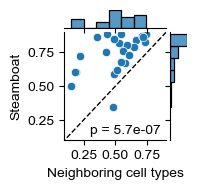

In [47]:
# fig, ax = plt.subplots(figsize=(2, 2))
# cellchat_corr_df.plot(kind='scatter', x='normneigh_r', y='steamboat_r', ax=ax)
g = sns.jointplot(
    data=cellchat_corr_df,
    x="adjacency_r", y="steamboat_r",
    kind="scatter",
    height=2,
    xlim=[0.1, .9],
    ylim=[0.1, .9]
)

ax = g.ax_joint

ax.set_xlabel('Neighboring cell types')
ax.set_ylabel('Steamboat')
ax.plot([.0, 1.], [.0, 1.], ls='--', lw=1., c='k')

test_res = sp.stats.wilcoxon(cellchat_corr_df['adjacency_r'], cellchat_corr_df['steamboat_r'])

ax.text(0.3, 0.15, f'p = {test_res.pvalue:.1e}')
(cellchat_corr_df['adjacency_r'] < cellchat_corr_df['steamboat_r']).sum() / cellchat_corr_df.shape[0]

# for pos in ['right', 'top']:
#    ax.spines[pos].set_visible(False)

# g.savefig("C:/Users/lshh/OneDrive/Publications/Steamboat/pub/fig-hgsc-elements/steamboat_vs_adjacency.pdf", **pltkw)

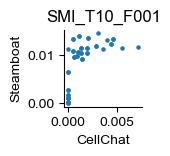

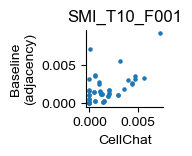

In [48]:
sample = 'SMI_T10_F001'
fig, ax = plt.subplots(figsize=(1., 1.))
cellchat_melt_dict[sample].plot(kind='scatter', x='value_cellchat', y='value_steamboat', ax=ax, title=sample, s=5.)

ax.set_xlabel('CellChat')
ax.set_ylabel('Steamboat')
for pos in ['right', 'top']:
        plt.gca().spines[pos].set_visible(False)
fig.savefig(f"C:/Users/lshh/OneDrive/Publications/Steamboat/pub/fig-hgsc-elements/steamboat_{sample}.pdf", **pltkw)

fig, ax = plt.subplots(figsize=(1., 1.))
cellchat_melt_dict[sample].plot(kind='scatter', x='value_cellchat', y='value_adjacency', ax=ax, title=sample, s=5.)

ax.set_xlabel('CellChat')
ax.set_ylabel('Baseline\n(adjacency)')
for pos in ['right', 'top']:
        plt.gca().spines[pos].set_visible(False)
fig.savefig(f"C:/Users/lshh/OneDrive/Publications/Steamboat/pub/fig-hgsc-elements/adjacency_{sample}.pdf", **pltkw)

## Misc visuals 

### Visualize cell scores from head #0, #5, #15

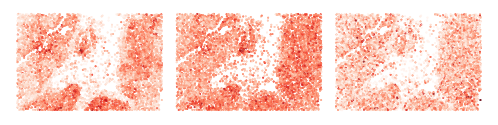

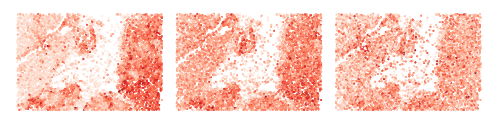

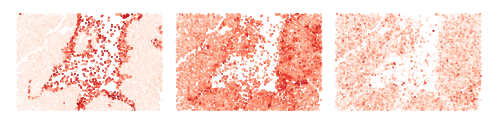

In [54]:
for i_head in [0, 5, 15]:
    adatas[0].obs[f'q_{i_head}'] = adatas[0].obsm['q'][:, i_head]
    adatas[0].obs[f'local_k_{i_head}'] = adatas[0].obsm['local_k'][:, i_head]
    adatas[0].obs[f'global_k_0_{i_head}'] = adatas[0].obsm['global_k_0'][:, i_head]
    sq.pl.spatial_scatter(adatas[0], color=[f'q_score_{i_head}', f'local_k_{i_head}', f'global_k_0_{i_head}'], shape=None, figsize=(2, 2), size=.5, 
                          legend_fontsize=10, cmap='Reds', ncols=3, colorbar=False, vmin=0., wspace=.0, outline=False, frameon=False, title="")

### Print top ranked genes in head #15

In [55]:
k15 = pd.Series(model.spatial_gather.k_regionals[0].weight[15, :].detach().cpu().numpy().tolist(), index=model.features).sort_values(ascending=False)
print(*k15[:20].index, sep=' ')

AGR2 GDF15 COL9A1 CEACAM6 PGR PLAC8 MMP8 KRT5 DDIT3 PROK2 COL5A3 MMP7 IFIH1 DDR2 MAML2 ITGAV NLRP2 TUBB4B LAMP3 INHBA


### UMAP of cell embeddings

In [57]:
adata = all_adata[~all_adata.obs['cell.types'].str.contains('_LC')]
adata.obsm['std_attn'] = adata.obsm['attn'] / adata.obsm['attn'].std(axis=0, keepdims=True)
sc.pp.neighbors(adata, use_rep='std_attn', key_added='sf', metric='cosine')
sc.tl.umap(adata, neighbors_key='sf')

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = 

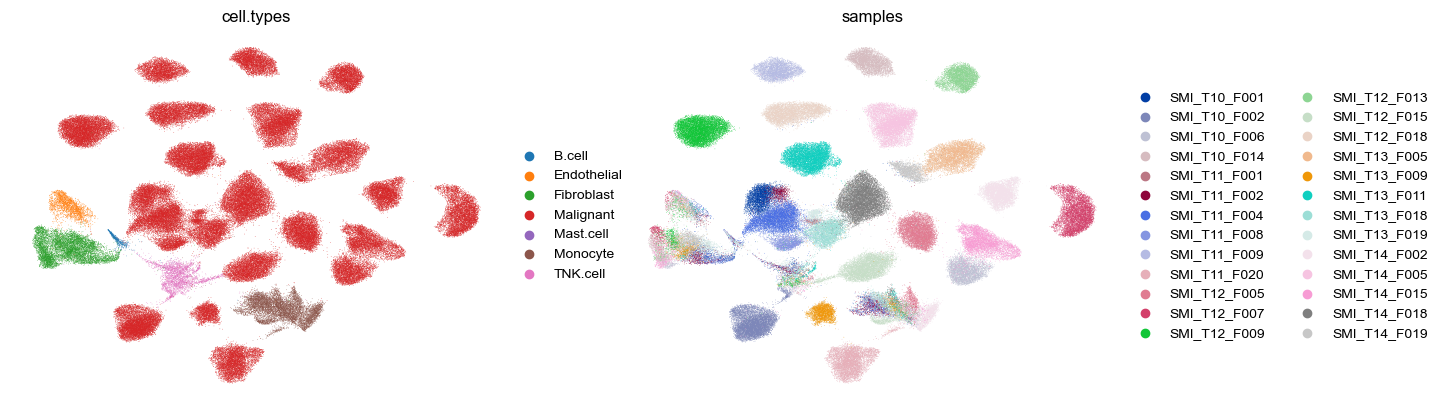

In [59]:
sc.pl.umap(adata, color=['cell.types', 'samples'], frameon=False)